In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *
from fastai2.medical.imaging import *

import pydicom

import pandas as pd

In [ ]:
from nbdev.showdoc import *

# Tutorial - Classification with X-rays

> In this tutorial we will build a classifier that distinguishes between X-rays with pneumothorax and X-rays without pneumothorax.

## Import X-rays

### Loading the data with `Datasets`

TODO: UPDATE TEXT: To load the data with the medium-level API `Datasets`, we need to gather all the images and define some way to split them between training and validation sets.

In [ ]:
pneumothorax_source = Path("/home/moritz/Documents/siim/dicom-images-train/")

# TODO: create small dataset and use the following structure:
# pneumothorax_source = untar_data(URLs.XRAY_TINY)

items = get_dicom_files(pneumothorax_source)
trn,val = RandomSplitter()(items)

items[0].dcmread().show()

TODO: UPDATE TEXT: Then we detail the type transforms (applied to the items to form a tuple) and the dataset transforms. For our inputs we use `PILImage.create` and for our targets, the `parent_label` function to convert a filename to its class, followed by `Categorize`. We'll also map the wordnet category ids used in Imagenette to words.

The dataset transforms contain data augmentation using PIL and a resize to 128.

Next, we need to load the labels for the dataset. In this case, the labels indicate whether the xray shows a pneumothorax or not.

In [ ]:
df = pd.read_csv("/home/moritz/Documents/siim/train-binary-classification.csv")
df.head()

,ImageId,Pneumothorax,Folder
0,1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819,No Pneumothorax,/home/moritz/Documents/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.6904.1517875201.850818/1.2.276.0.7230010.3.1.3.8323329.6904.1517875201.850817/1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819.dcm
1,1.2.276.0.7230010.3.1.4.8323329.13666.1517875247.117800,Pneumothorax,/home/moritz/Documents/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.13666.1517875247.117799/1.2.276.0.7230010.3.1.3.8323329.13666.1517875247.117798/1.2.276.0.7230010.3.1.4.8323329.13666.1517875247.117800.dcm
2,1.2.276.0.7230010.3.1.4.8323329.11028.1517875229.983789,No Pneumothorax,/home/moritz/Documents/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.11028.1517875229.983788/1.2.276.0.7230010.3.1.3.8323329.11028.1517875229.983787/1.2.276.0.7230010.3.1.4.8323329.11028.1517875229.983789.dcm
3,1.2.276.0.7230010.3.1.4.8323329.10366.1517875223.393986,Pneumothorax,/home/moritz/Documents/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10366.1517875223.393985/1.2.276.0.7230010.3.1.3.8323329.10366.1517875223.393984/1.2.276.0.7230010.3.1.4.8323329.10366.1517875223.393986.dcm
4,1.2.276.0.7230010.3.1.4.8323329.10016.1517875220.992175,Pneumothorax,/home/moritz/Documents/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10016.1517875220.992174/1.2.276.0.7230010.3.1.3.8323329.10016.1517875220.992173/1.2.276.0.7230010.3.1.4.8323329.10016.1517875220.992175.dcm


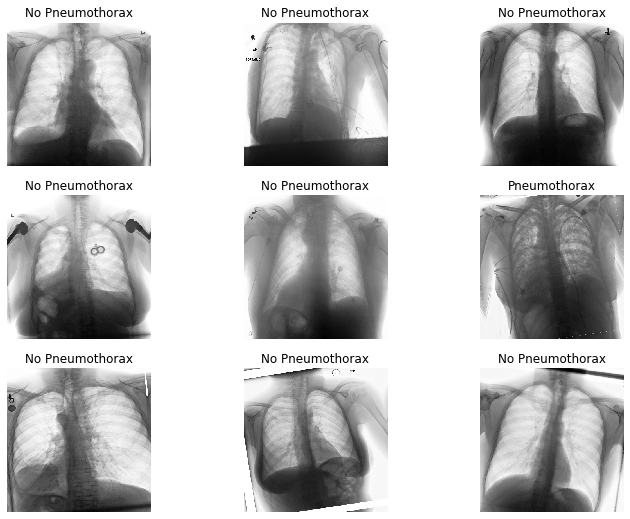

In [ ]:
pneumothorax = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                   get_x=lambda x:x[2],
                   splitter=RandomSplitter(),
                   get_y=lambda x:x[1],
                   batch_tfms=aug_transforms(size=512, flip_vert=False, max_lighting=0.1, max_zoom=1.05, max_warp=0.))

dls = pneumothorax.dataloaders(df.values)
dls.show_batch(max_n=9, figsize=(12,9))

We can then pass all of this information to `Datasets`.

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=accuracy_multi)
learn.fit_one_cycle(1)

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 3.95 GiB total capacity; 2.58 GiB already allocated; 475.19 MiB free; 2.71 GiB reserved in total by PyTorch)

To convert our `Datasets` to a `DataLoaders`, we need to indicate the transforms we want to use at the batch level, here putting on the GPU with `Cuda`, converting the tensors of bytes to float then normalizing using the traditional imagenet statistics.

### Loading the data with `DataBlock`

An easier way is to use the `DataBlock` higher-level API. We just need to specify the types, how to get the items, how to split them and how to label to build an Imagenette datablock.

In [ ]:
imagenette = DataBlock(blocks=(ImageBlock, CategoryBlock), 
                       get_items=get_image_files, 
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_y=[parent_label,lbl_dict.__getitem__],
                       item_tfms=item_img_tfms, 
                       batch_tfms=Normalize.from_stats(*imagenet_stats))

We can then directly call the `dataloaders` method when specifying a source (where the items are) and the non-default dataset and dataloader transforms. To check which transforms are included by default (inferred from the types passed), we can check (and potentially modify) the attributes `default_type_tfms`, `default_item_tfms` and `default_batch_tfms` of the `imagenette` object.

### Training

The following function will give us a `Learner` to train a model on imagenette.

In [ ]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(Adam, wd=0.01, eps=1e-3)
               ).to_fp16()

Then we can train our model.

In [ ]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,accuracy,time
0,2.364704,2.153578,0.593121,00:18


## Showing results

To get predictions on one item, we use `Learner.predict`

In [ ]:
tst_item = items[0]
t = learn.predict(tst_item)

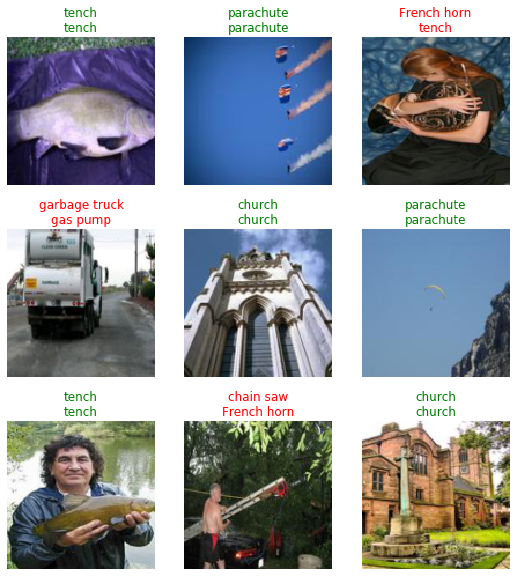

In [ ]:
learn.show_results()

### Side note: using a PyTorch optimizer

In [ ]:
@delegates(torch.optim.AdamW.__init__)
def pytorch_adamw(params, **kwargs):
    return OptimWrapper(torch.optim.AdamW(params, **kwargs))

In [ ]:
learn = Learner(dls, xresnet18(), lr=1e-2, metrics=accuracy,
                loss_func=LabelSmoothingCrossEntropy(),
                opt_func=partial(pytorch_adamw, wd=0.01, eps=1e-3)
               ).to_fp16()

## Rect training (not working well)

For a rectangular training, we change the dataset transforms to use the flip only. We will resize the images when it's time to batch them only.

In [ ]:
#img_tfms = [FlipItem(0.5)]
#tfms = [PILImage.create, [parent_label, Categorize()]]
#dsets = Datasets(items, tfms, splits=split_idx, item_tfms=img_tfms)

#tfms = [Cuda(), IntToFloatTensor(), Normalize(*imagenet_stats)]
#bs = 64

We use a sampler that will group the images by batches of the close size and aspect ratio (with a bit of shuffle for the training set) and a collation function that will resize them to the mdeian aspect ratio and median number of pixel (bound by `max_px`). `rand_min_scale` is used to do a `RandomResizedCrop` to that size on the training set.

In [ ]:
#samp = SortARSampler(dsets.train, shuffle=True, bs=bs)
#collate_fn = ResizeCollate(max_px=128*128, rand_min_scale=0.35, rand_ratio_pct=0.33, round_mult=32)
#train_dl = TfmdDL(dsets.train, tfms, num_workers=8, batch_sampler=samp, collate_fn=collate_fn)

#samp = SortARSampler(dsets.valid, shuffle=False, bs=bs)
#collate_fn = ResizeCollate(max_px=128*128, round_mult=32)
#valid_dl = TfmdDL(dsets.valid, tfms, num_workers=8, batch_sampler=samp, collate_fn=collate_fn)

Then we create a `DataLoaders` with those two dataloaders.

In [ ]:
#dls1 = imagenette.dataloaders(source, bs=64, num_workers=8, item_tfms=item_img_tfms, batch_tfms=Normalize(*imagenet_stats))

#dls = DataLoaders(train_dl, valid_dl)
#dls.show_batch(max_n=9)

In [ ]:
#learn = cnn_learner(xresnet18, dls, LabelSmoothingCrossEntropy(), opt_func=opt_func, c_in=3, c_out=10, lr=1e-2, metrics=accuracy)
#learn.fit_one_cycle(1)